In [1]:
%cd ../

%load_ext autoreload
%autoreload 2

/home/hoanghu/projects/Food-Waste-Optimization


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from darts import TimeSeries

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Read dataset

In [4]:
path_processed = "experiments_hoangle/processed/tuntidata_processed.csv"
path = "src/data/basic_mvp_data/tuntidata2.xlsx"

In [5]:
df_raw = pd.read_excel(path, header=0)

df_raw.head(10)

,Date,Kuitin tunti,Ravintola,Kuitti kpl
0,2023-01-02,8,600 Chemicum,1
1,2023-01-02,10,600 Chemicum,18
2,2023-01-02,11,600 Chemicum,83
3,2023-01-02,12,600 Chemicum,79
4,2023-01-02,13,600 Chemicum,90
5,2023-01-02,14,600 Chemicum,1
6,2023-01-03,8,600 Chemicum,1
7,2023-01-03,10,600 Chemicum,26
8,2023-01-03,11,600 Chemicum,88
9,2023-01-03,12,600 Chemicum,94


# Pre-process

In [6]:
## Rename columns
df = df_raw.rename(columns={
    'Date': 'date',
    'Kuitin tunti': 'hour',
    'Ravintola': 'restaurant',
    'Kuitti kpl': 'pcs'
})

datetime = []
for x in df.itertuples():
    datetime.append(x.date.replace(hour=x.hour))

df.loc[:, 'datetime'] = datetime


df.head()

,date,hour,restaurant,pcs,datetime
0,2023-01-02,8,600 Chemicum,1,2023-01-02 08:00:00
1,2023-01-02,10,600 Chemicum,18,2023-01-02 10:00:00
2,2023-01-02,11,600 Chemicum,83,2023-01-02 11:00:00
3,2023-01-02,12,600 Chemicum,79,2023-01-02 12:00:00
4,2023-01-02,13,600 Chemicum,90,2023-01-02 13:00:00


### Create new dataframe with pre-defined datetime

In [7]:
freq = pd.offsets.CustomBusinessHour(start="8:00", end="17:00", weekmask="Mon Tue Wed Thu Fri")

date_start = df['date'].min().replace(hour=8)
date_end = df['date'].max().replace(hour=16)

date_range = pd.date_range(start=date_start, end=date_end, freq=freq)

df_new = pd.DataFrame({
    'datetime': date_range
})

df_new.head()

,datetime
0,2023-01-02 08:00:00
1,2023-01-02 09:00:00
2,2023-01-02 10:00:00
3,2023-01-02 11:00:00
4,2023-01-02 12:00:00


In [8]:
for restaurant in df['restaurant'].unique():
    df_restaurant = df[df['restaurant'] == restaurant][['datetime', 'pcs']]

    df_new = df_new\
        .merge(df_restaurant, on='datetime', how='left')\
        .rename(columns={'pcs': restaurant})

df = df_new.copy()

df.head()

,datetime,600 Chemicum,610 Physicum,620 Exactum
0,2023-01-02 08:00:00,1.0,NaN,NaN
1,2023-01-02 09:00:00,NaN,NaN,NaN
2,2023-01-02 10:00:00,18.0,NaN,NaN
3,2023-01-02 11:00:00,83.0,NaN,NaN
4,2023-01-02 12:00:00,79.0,NaN,NaN


### Fill NaN values

#### Determine the historical correlation in each restaurant

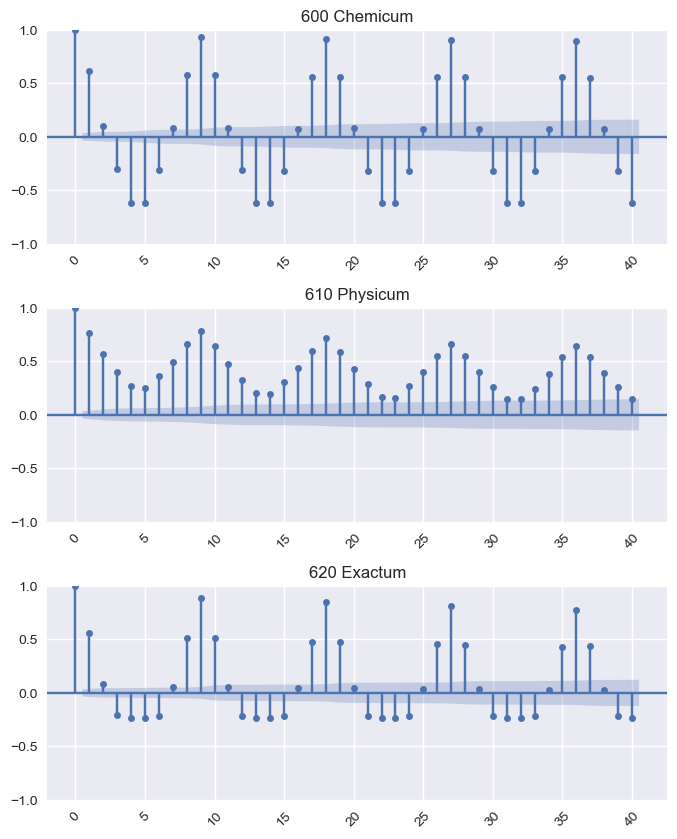

In [9]:
restaurants = ['600 Chemicum', '610 Physicum', '620 Exactum']

fig = plt.figure(figsize=(8, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

for i, restaurant in enumerate(restaurants):
    sales = df[restaurant]
    
    ax = fig.add_subplot(3, 1, i+1)

    sm.graphics.tsa.plot_acf(sales.fillna(0), lags=40, ax=ax)
    ax.set_title(restaurant)
    ax.tick_params(axis='x', labelrotation = 45)

#### Conclusion:

In all restaurants, the sales is by hour dependent.

#### Fill NaN based on the conclusion

In [10]:
df.loc[:, 'hour'] = df['datetime'].apply(lambda x: x.hour)

In [11]:
df_mean_by_hour = df.copy()

df_mean_by_hour.loc[:, 'hour'] = df['datetime'].apply(lambda x: x.hour)

df_mean_by_hour = df_mean_by_hour\
    .groupby(by='hour')[restaurants]\
    .mean()\
    .reset_index()

df_mean_by_hour.head()

,hour,600 Chemicum,610 Physicum,620 Exactum
0,8,2.236686,21.093863,1.272727
1,9,2.696246,30.945848,1.430769
2,10,35.719298,39.682310,2.024390
3,11,220.859649,60.064982,138.035398
4,12,224.116959,67.358423,121.495575


In [12]:
for restaurant in restaurants:
    for hour in df['hour'].unique():
        indices = df[
            (df[restaurant].isna())
            & (df['hour'] == hour)
        ].index

        value_filled = df_mean_by_hour[(df_mean_by_hour['hour'] == hour)][restaurant].item()

        df.loc[indices, restaurant] = value_filled

# NOTE: HoangLe [Jun-26]: There is still NaN values in '620 Exactum' at 'hour = 15', since at this time, UniCafe in Exactume is closed

In [13]:
df = df.drop(columns=['hour'])

### Create TimeSeries based on newly created dataframe

<Axes: xlabel='datetime'>

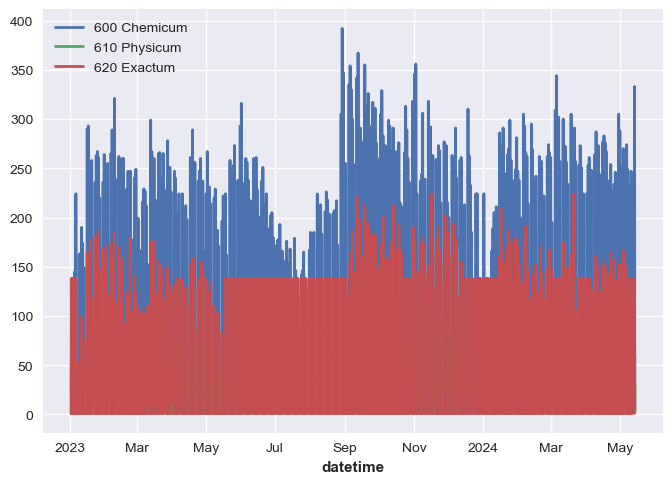

In [14]:
series = TimeSeries.from_dataframe(
    df=df,
    time_col='datetime',
    freq=freq,
    fill_missing_dates = False,
    value_cols=restaurants
)

series.plot()

In [15]:
# df.to_csv(path_processed, index=False)

# Plots & Test

In [18]:
df_visualize = df.copy()

In [21]:
stationary_pval = []

for restaurant in restaurants:
    adf_pval = adfuller(df_visualize['600 Chemicum'])[1]
    kpss_pval = kpss(df_visualize['600 Chemicum'])[1]

    stationary_pval.extend(
    [
        {
            'restaurant': restaurant,
            'test_type': 'adf',
            'pval': adf_pval
        },
        {
            'restaurant': restaurant,
            'test_type': 'kpss',
            'pval': kpss_pval
        },
    ])

In [23]:
df_stationary = pd.DataFrame.from_records(stationary_pval)

df_stationary.head()

,restaurant,test_type,pval
0,600 Chemicum,adf,0.000297
1,600 Chemicum,kpss,0.081376
2,610 Physicum,adf,0.000297
3,610 Physicum,kpss,0.081376
4,620 Exactum,adf,0.000297


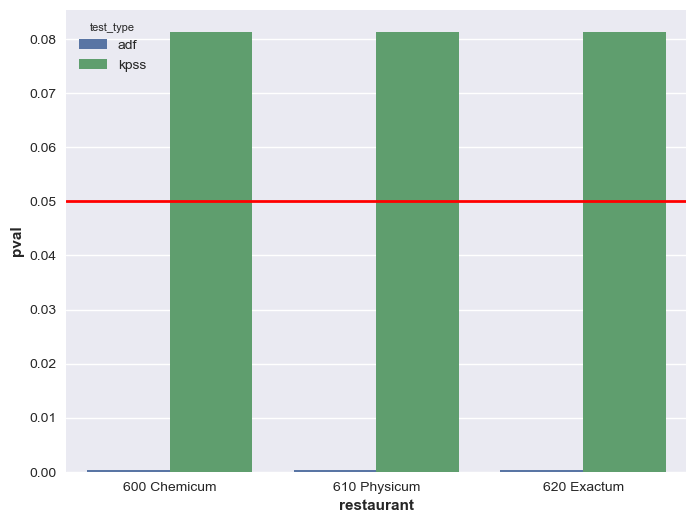

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.barplot(data=df_stationary, x='restaurant', y='pval', hue='test_type', ax=ax)
ax.axhline(y=0.05, c='r', linestyle = '-', linewidth=2)

In [101]:
df_visualize.loc[:, 'hour'] = df_visualize['datetime'].apply(lambda x: x.hour)
df_visualize.loc[:, 'weekday'] = df_visualize['datetime'].apply(lambda x: x.weekday())

df_visualize.head()

,datetime,600 Chemicum,610 Physicum,620 Exactum,hour,weekday
0,2023-01-02 08:00:00,1.000000,21.093863,1.272727,8,0
1,2023-01-02 09:00:00,2.696246,30.945848,1.430769,9,0
2,2023-01-02 10:00:00,18.000000,39.682310,2.024390,10,0
3,2023-01-02 11:00:00,83.000000,60.064982,138.035398,11,0
4,2023-01-02 12:00:00,79.000000,67.358423,121.495575,12,0


In [102]:
indices_subfigs = [i+1 for i in range(len(df_visualize['hour'].unique()) * len(restaurants))]
i = 0

for hour in df_visualize['hour'].unique():
    for restaurant in restaurants:
        

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16])

KeyError: 'hour'

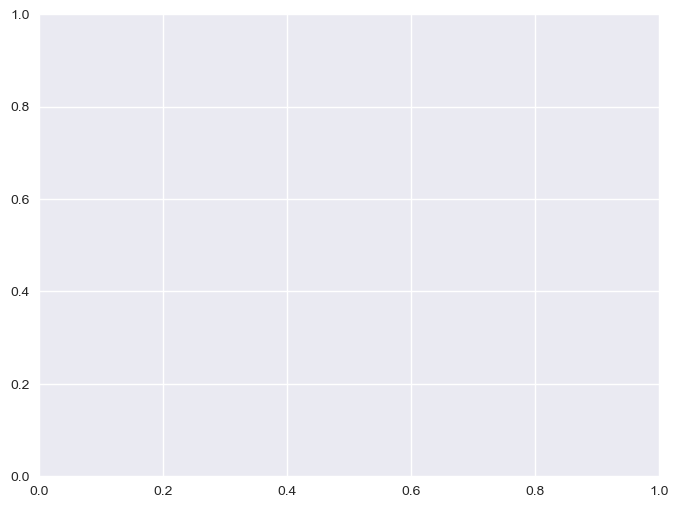

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.barplot(df.groupby('hour')['pcs'].sum(), ax=ax)

<Axes: xlabel='weekday', ylabel='pcs'>

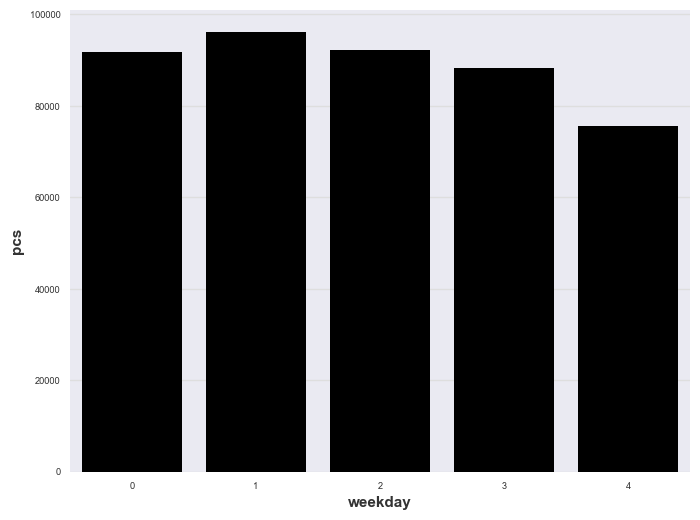

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.barplot(df.groupby('weekday')['pcs'].sum(), ax=ax)

<Axes: xlabel='datetime'>

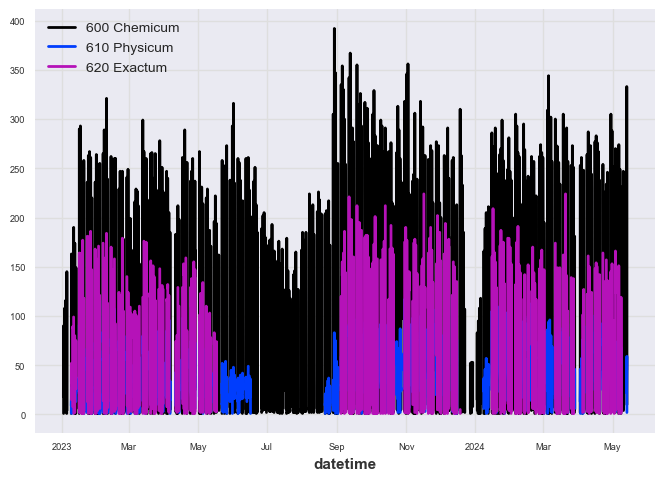

In [ ]:
series.plot()

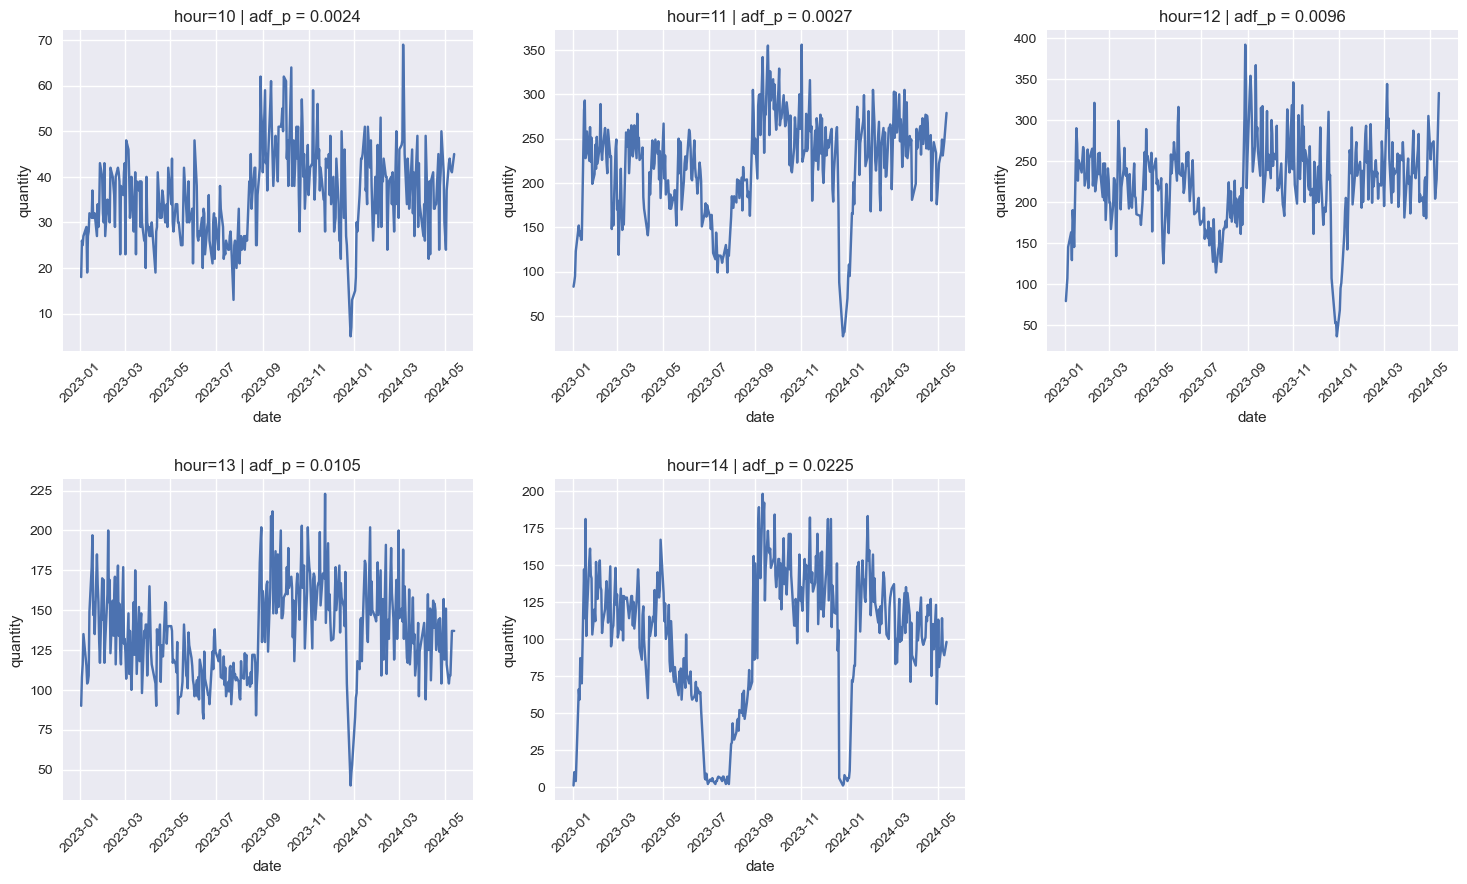

In [ ]:
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

for i, hour in enumerate(df_waste_processed['hour'].unique()):
    df_hour = df_waste_processed[df_waste_processed['hour'] == hour]

    p_val = adfuller(df_hour['quantity'])[1]


    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(df_hour, x='date', y='quantity', ax=ax)
    ax.set_title(f"hour={hour} | adf_p = {p_val:.4f}")
    ax.tick_params(axis='x', labelrotation = 45)